In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns
import torch.nn as nn
import torch
import os
#import math
#import pandas as pd
#from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#import pickle
import torchvision
from torch.optim import SGD, Adam
from crp.image import imgify, vis_opaque_img, plot_grid

#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
#from torch.autograd import Variable

from tqdm import tqdm 

import tigramite
from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [ ]:
index = 0
q_dir = "clevr-xai/ground_truth_simple_questions_single_object"
q_path = os.path.join(q_dir, f'{index}.npy')
question = np.load(q_path)
print(question)

In [4]:
# Trying out MNIST instead of dsprites
BATCH_SIZE = 128

transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])

mnist_dataset = torchvision.datasets.MNIST(root="",train=True, download=True, transform=transform)
mnist_dataset_test = torchvision.datasets.MNIST(root="",train=False, download=True, transform=transform)

training_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class ShapeConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ShapeConvolutionalNeuralNetwork, self).__init__()
        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=7, stride=2, padding=0),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
model = ShapeConvolutionalNeuralNetwork()
model.eval()
dataiter = iter(training_loader)
images, labels = next(dataiter)
res = model(images)
print(res.data.max(1, keepdim=True)[1], labels, images.shape)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [191]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    correct = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in (pbar := tqdm(enumerate(training_loader))):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            nccorrect = correct / (BATCH_SIZE)
            pbar.set_description('  batch {} correct {}%'.format(i + 1, np.round(nccorrect,2)))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.
            correct = 0

    return last_loss

In [192]:
def train_network():
    epoch_number = 0
    EPOCHS = 7
    best_vloss = 1_000_000.
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number)   
        # save the model's state
        model_path = 'model_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)

        epoch_number += 1

# only needed for retraining     
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.03, momentum=0.5, dampening=0.01)
train_network()

EPOCH 1:


  batch 400 correct 89.82%: : 469it [00:04, 95.18it/s] 


EPOCH 2:


  batch 400 correct 94.08%: : 469it [00:05, 93.56it/s] 


EPOCH 3:


  batch 400 correct 95.84%: : 469it [00:04, 96.95it/s] 


EPOCH 4:


  batch 400 correct 96.45%: : 469it [00:04, 95.86it/s] 


EPOCH 5:


  batch 400 correct 96.98%: : 469it [00:05, 90.85it/s] 


EPOCH 6:


  batch 400 correct 97.02%: : 469it [00:04, 96.65it/s] 


EPOCH 7:


  batch 400 correct 97.7%: : 469it [00:04, 94.99it/s]  


In [7]:
PATH = "model_mnist.pickle"
#torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

fv_path = "crp-stuff/mnist"
fv = FeatureVisualization(attribution, mnist_dataset, layer_map, path=fv_path)
layer_names

['convolutional_layers.0',
 'convolutional_layers.2',
 'linear_layers.0',
 'linear_layers.2']

label 4,prediction:4 top 6 concepts: tensor([ 4,  9,  3, 12,  7, 14]), their relevances: tensor([26.6316, 12.5210, 11.9177,  9.6569,  8.8145,  6.2455])


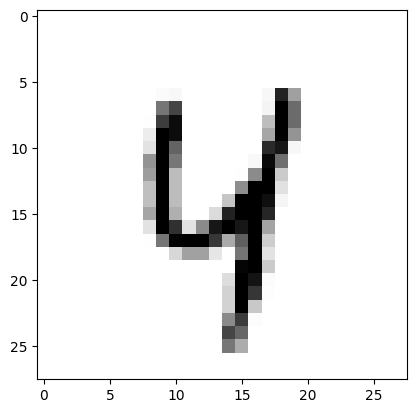

In [11]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

index = 10
label = labels[index]
img = images[index]
sample = img.view(1,1,28,28)
sample.requires_grad = True
cond_layer = 'convolutional_layers.2'

conditions = [{'y': [label]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
pred = attr.prediction.max(1, keepdim=True)[1]
plt.imshow(img[0], cmap="Greys")

rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
# the ten most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(f'label {label},prediction:{pred[0][0]} top 6 concepts: {concept_ids}, their relevances: {rel_values*100}')
#conditions = [{cond_layer: [id], 'y': [label]} for id in concept_ids]
#heatmap, a, b, c = attribution(sample, conditions, composite)
#imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)),resize=700)

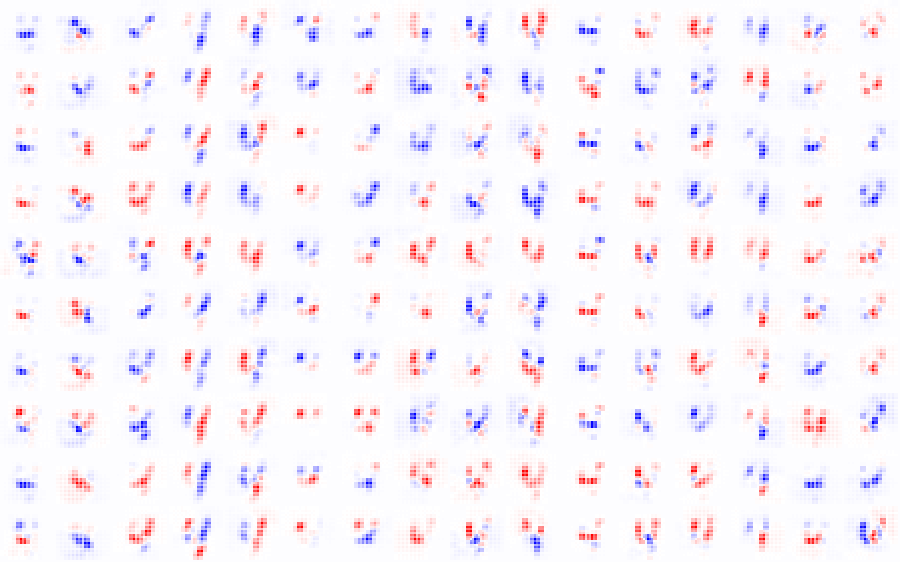

In [12]:

cond_layer = 'convolutional_layers.2'

conditions = [{ 'linear_layers.2':[i], cond_layer:[j] } for i in range(10) for j in range(16)] #,'convolutional_layers.0':[i]
attr = attribution(sample, conditions, composite, record_layer=layer_names, start_layer='linear_layers.2')

imgify(attr.heatmap, resize=900,grid=(10, 16), symmetric=True)
#all_vals = {f'class {i}':attr.heatmap[i*16:(i+1)*16] for i in range(10)}
#plot_grid(all_vals, figsize=(16, 10),cmap="Greys", symmetric=True,)

In [330]:
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[layer], abs_norm=True)
    return [rel_c[0][i] for i in neurons]

In [19]:
def get_top_k_neurons(img, label, layer, neurons, k=10):
    top_k_per_neuron = []
    for neuron in neurons:
        conditions = [{cond_layer: [neuron], 'y': [label]}]
        attr = attribution(img, conditions, composite, record_layer=layer_names)
        rel_c = cc.attribute(attr.relevances[layer], abs_norm=True)
        rel_values, concept_ids = torch.topk(rel_c[0], 10)
        print(concept_ids)
        top_k_per_neuron.append(concept_ids)
    return np.array(top_k_per_neuron, dtype=np.int32)

In [20]:
pool_img = torch.nn.MaxPool2d(4, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

def make_reduced_heatmap(img,conditions):
    attr = attribution(img, conditions, composite, record_layer=layer_names)

    if np.count_nonzero(attr.heatmap) == 0:
        print("is empty", conditions)
    hmap = attr.heatmap[:, 4:, 4:]
    #print(hmap.shape)
    hmap = hmap[:,:56, :56]
    #print(hmap.shape)
    hmap = pool_img(hmap)
    hmap = hmap.view(hmap.size(0), -1)
    return hmap
    

def get_heatmaps(img, label, layer, neurons):
    heatmaps = np.empty((len(neurons)+1, 196))
    heatmaps[0] = make_reduced_heatmap(img, [{'y': [label]}])
    i = 1
    for neuron in neurons:
        conditions = [{cond_layer: [neuron], 'y': [label]}]
        heatmaps[i] = make_reduced_heatmap(img,conditions)
        i += 1
    return heatmaps

In [21]:
def draw_heatmaps_values(size,cond_layer,neurons, shape):
    samples = []
    dataiter = iter(test_loader)
    for blub in range(size):
        images, labels, indices = next(dataiter)
        images = images.view((BATCH_SIZE, 1,64,64))
        for i in range(len(labels)):
            # only specific shape
            label = labels[i]
            if isinstance(shape, int) and label != shape:
                continue
            sample = images[i].view(1,1,64,64)
            sample.requires_grad = True
            # add heatmaps for neurons + label
            in_variables = get_heatmaps(sample, label, cond_layer, neurons)
            if not np.all(np.isfinite(in_variables)):
                print(i)
            samples.append(in_variables)
    return np.array(samples, dtype=np.float64)


In [197]:
from crp.cache import ImageCache

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

cache = ImageCache(path="cache")

fv = FeatureVisualization(attribution, mnist_dataset, layer_map, path=fv_path, cache=cache)

In [ ]:
from crp.helper import get_output_shapes
import numpy as np

def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=False,alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

In [13]:
def draw_top_references():
    data = np.zeros((10,74,784))
    var_names = []
    for k,v in layer_id_map.items(): 
        ref_c = fv.get_max_reference(v, k, "relevance", (0, 10), plot_fn=vis_simple)
        for i, neur in  enumerate(ref_c.values()):
            for obs, ref_sample in enumerate(neur): 
                flat_img = np.array(ref_sample, dtype=np.float64).flatten()
                data[obs] += flat_img
            var_names += [f'{k}_{i}']
    dataframe = pp.DataFrame(np.array(data, dtype=np.float64), var_names=var_names, analysis_mode="multiple")
    return dataframe
#dataframe = draw_top_references()

In [365]:
def draw_reference_score_values(size,cond_layer,neurons):
    variables = []
    dataiter = iter(test_loader)
    for blub in range(size):
        images, labels = next(dataiter)
        images = images.view((BATCH_SIZE, 1,28,28))
        for i in range(len(labels)):
            # only specific shape
            label = labels[i]
            img = images[i]
            sample = img.view(1,1,28,28)
            sample.requires_grad = True
            #output = model(sample)
            #pred = output.data
            #prediction = list(pred[:][0])
            #in_variables = prediction
            # add relevance scores for neurons 
            res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables = res
            if not np.all(np.isfinite(in_variables)):
                print(index)
            variables.append(in_variables)
    return np.array(variables, dtype=np.float64)

def draw_complete_ref_score_values(size,layers, shape=None):
    variables = []
    dataiter = iter(test_loader)
    while len(variables) < size:
        images, labels = next(dataiter)
        images = images#.view((BATCH_SIZE, 1,28,28))
        for i in range(len(labels)):
            # only specific shape
            label = labels[i]
            if shape is not None and label != shape:
                continue
            img = images[i]
            sample = img.view(1,1,28,28)
            sample.requires_grad = True 
            in_variables = []
            for x in layers:
                cond_layer = x[0]
                neurons = x[1]
                res = get_reference_scores(sample, label, cond_layer, neurons)
                in_variables += res
            if not np.all(np.isfinite(in_variables)):
                print(index)
            variables.append(in_variables)
            if len(variables) == size:
                break
    return np.array(variables, dtype=np.float64)

In [332]:
def create_dataframe(cond_layer, neurons, size=2):
    neuron_names = [f"{cond_layer[0:4]}{cond_layer[-1]}_{k}" for k in neurons]
    class_names = [f"class_{i}" for i in range(10)]
    var_names = neuron_names  # class_names +
    # choose from functions: draw_top_k_references_values, draw_heatmaps_values,  draw_reference_score_values
    data = draw_reference_score_values(size, cond_layer, neurons)
    print(data.shape)
    # sanity test that variable names are correct
    print(
        f"number of intended variables: {len(var_names)}, actual number: {len(data[0])}, length of dataset: {len(data)}"
    )
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe, var_names


def create_complete_df(layers, shape=None):
    var_names = np.array([
        f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]
    ])
    data = draw_complete_ref_score_values(600, layers, shape)
    empty_vars = np.where(~data.any(axis=0))
    print(empty_vars)
    #data = np.delete(data, empty_vars, axis=1)
    #var_names = np.delete(var_names, empty_vars)
    #print(var_names)
    # sanity test that variable names are correct
    print(
        f"number of intended variables: {var_names.shape}, shape of dataset: {data.shape}"
    )
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe, var_names

In [367]:
def create_complete_df(layers, shape=None):
    var_names = np.array([
        f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]
    ])
    data = draw_complete_ref_score_values(600, layers, shape)
    empty_vars = np.where(~data.any(axis=0))
    print(empty_vars)
    #data = np.delete(data, empty_vars, axis=1)
    #var_names = np.delete(var_names, empty_vars)
    #print(var_names)
    # sanity test that variable names are correct
    print(
        f"number of intended variables: {var_names.shape}, shape of dataset: {data.shape}"
    )
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe, var_names

In [502]:
def make_nn_link_assumptions(layers, same_layer=False):
    link_assumptions = {}
    index = 0
    layerEnd = 0
    for l in range(len(layers)):
        previousEnd = layerEnd
        layerEnd += len(layers[l][1])
        for neuron in layers[l][1]:
            if same_layer:
                link_assumptions[index] = {}
                for i in range(previousEnd, layerEnd):
                    if i != index:
                        link_assumptions[index][(i, 0)] = "o?o"
                        if i not in link_assumptions:
                            link_assumptions[i] = {}
                        link_assumptions[i][(index, 0)] = "o?o"
            if l + 1 < len(layers):
                if index not in link_assumptions:
                    link_assumptions[index] = {}
                for other_neuron in layers[l + 1][1]:
                    othern = layerEnd + other_neuron
                    link_assumptions[index][(othern, 0)] = "-?>"
                    if othern not in link_assumptions:
                        link_assumptions[othern] = {}
                    link_assumptions[othern][(index, 0)] = "<?-"
                index += 1
    return link_assumptions

In [503]:
# here you can use all existing layers and accordingly the set of neurons
layers = [["convolutional_layers.0",range(16)], ["convolutional_layers.2",range(16)], ["linear_layers.0",range(32)],["linear_layers.2",range(10)]] # ["convolutional_layers.0",16], ,["linear_layers.2",range(10)]

dataframe,var_names = create_complete_df(layers)


(array([], dtype=int64),)
number of intended variables: (74,), shape of dataset: (600, 74)


In [1]:
#ci_test = CMIknn(significance='fixed_thres', fixed_thres=0.04)
ci_test = RobustParCorr(significance="fixed_thres", fixed_thres=0.4)
#ci_test = GPDCtorch()
#ci_test = CMIsymb(significance='fixed_thres', fixed_thres=0.4)
#ci_test = RegressionCI(significance='analytic')
link_assumptions  = make_nn_link_assumptions(layers, False)

pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)

results = pcmci.run_pcmciplus(
    tau_max=0, pc_alpha=0.02, link_assumptions=link_assumptions
)


NameError: name 'RobustParCorr' is not defined

In [576]:
import networkx as nx


def plot_multipartite(graph_res, layers):
    link_matrix_upper = np.copy(graph_res["graph"])
    link_matrix_upper[:, :, 0] = np.triu(link_matrix_upper[:, :, 0])
    # net = _get_absmax(link_matrix != "")
    net = np.any(link_matrix_upper != "", axis=2)
    G = nx.DiGraph(net)
    node_labels = {}
    for i in G.nodes:
        n = 0
        if i < len(layers[0][1]):
            subset = 0
            layer = "convolutional_layers.0"
            n = i
        elif i < len(layers[0][1]) + len(layers[1][1]):
            subset = 1
            layer = "convolutional_layers.2"
            n = i - len(layers[0][1])
        elif i < len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]):
            subset = 2
            layer = "linear_layers.0"
            n = i - (len(layers[0][1]) + len(layers[1][1]))
        else:
            subset = 3
            layer = "linear_layers.2"
            n = i - (len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]))
        G.nodes[i]["subset"] = subset
        G.nodes[i]["layer"] = layer
        node_labels[i] = f"{layer[:3]}{layer[-1]}_{n}"

    pos = nx.multipartite_layout(G, subset_key="subset")

    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot(111, frame_on=False)
    # pos = nx.planar_layout(G)
    # unconnected = [node for node in G.nodes if (G.out_degree(node) == 0 and G.in_degree(node) == 0 )]
    # fixed = range(61,72)
    # pos = nx.spring_layout(G, pos=pos, scale=1, k=0.08)
    edge_color = [results["val_matrix"][i][j][0] for (i, j) in G.edges]
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        labels=node_labels,
        node_size=1000,
        linewidths=10,
        width=4,
        node_color="#aaaaaa",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.bwr,
        edge_color=edge_color,
        connectionstyle="arc3,rad=0.1",
    ) 

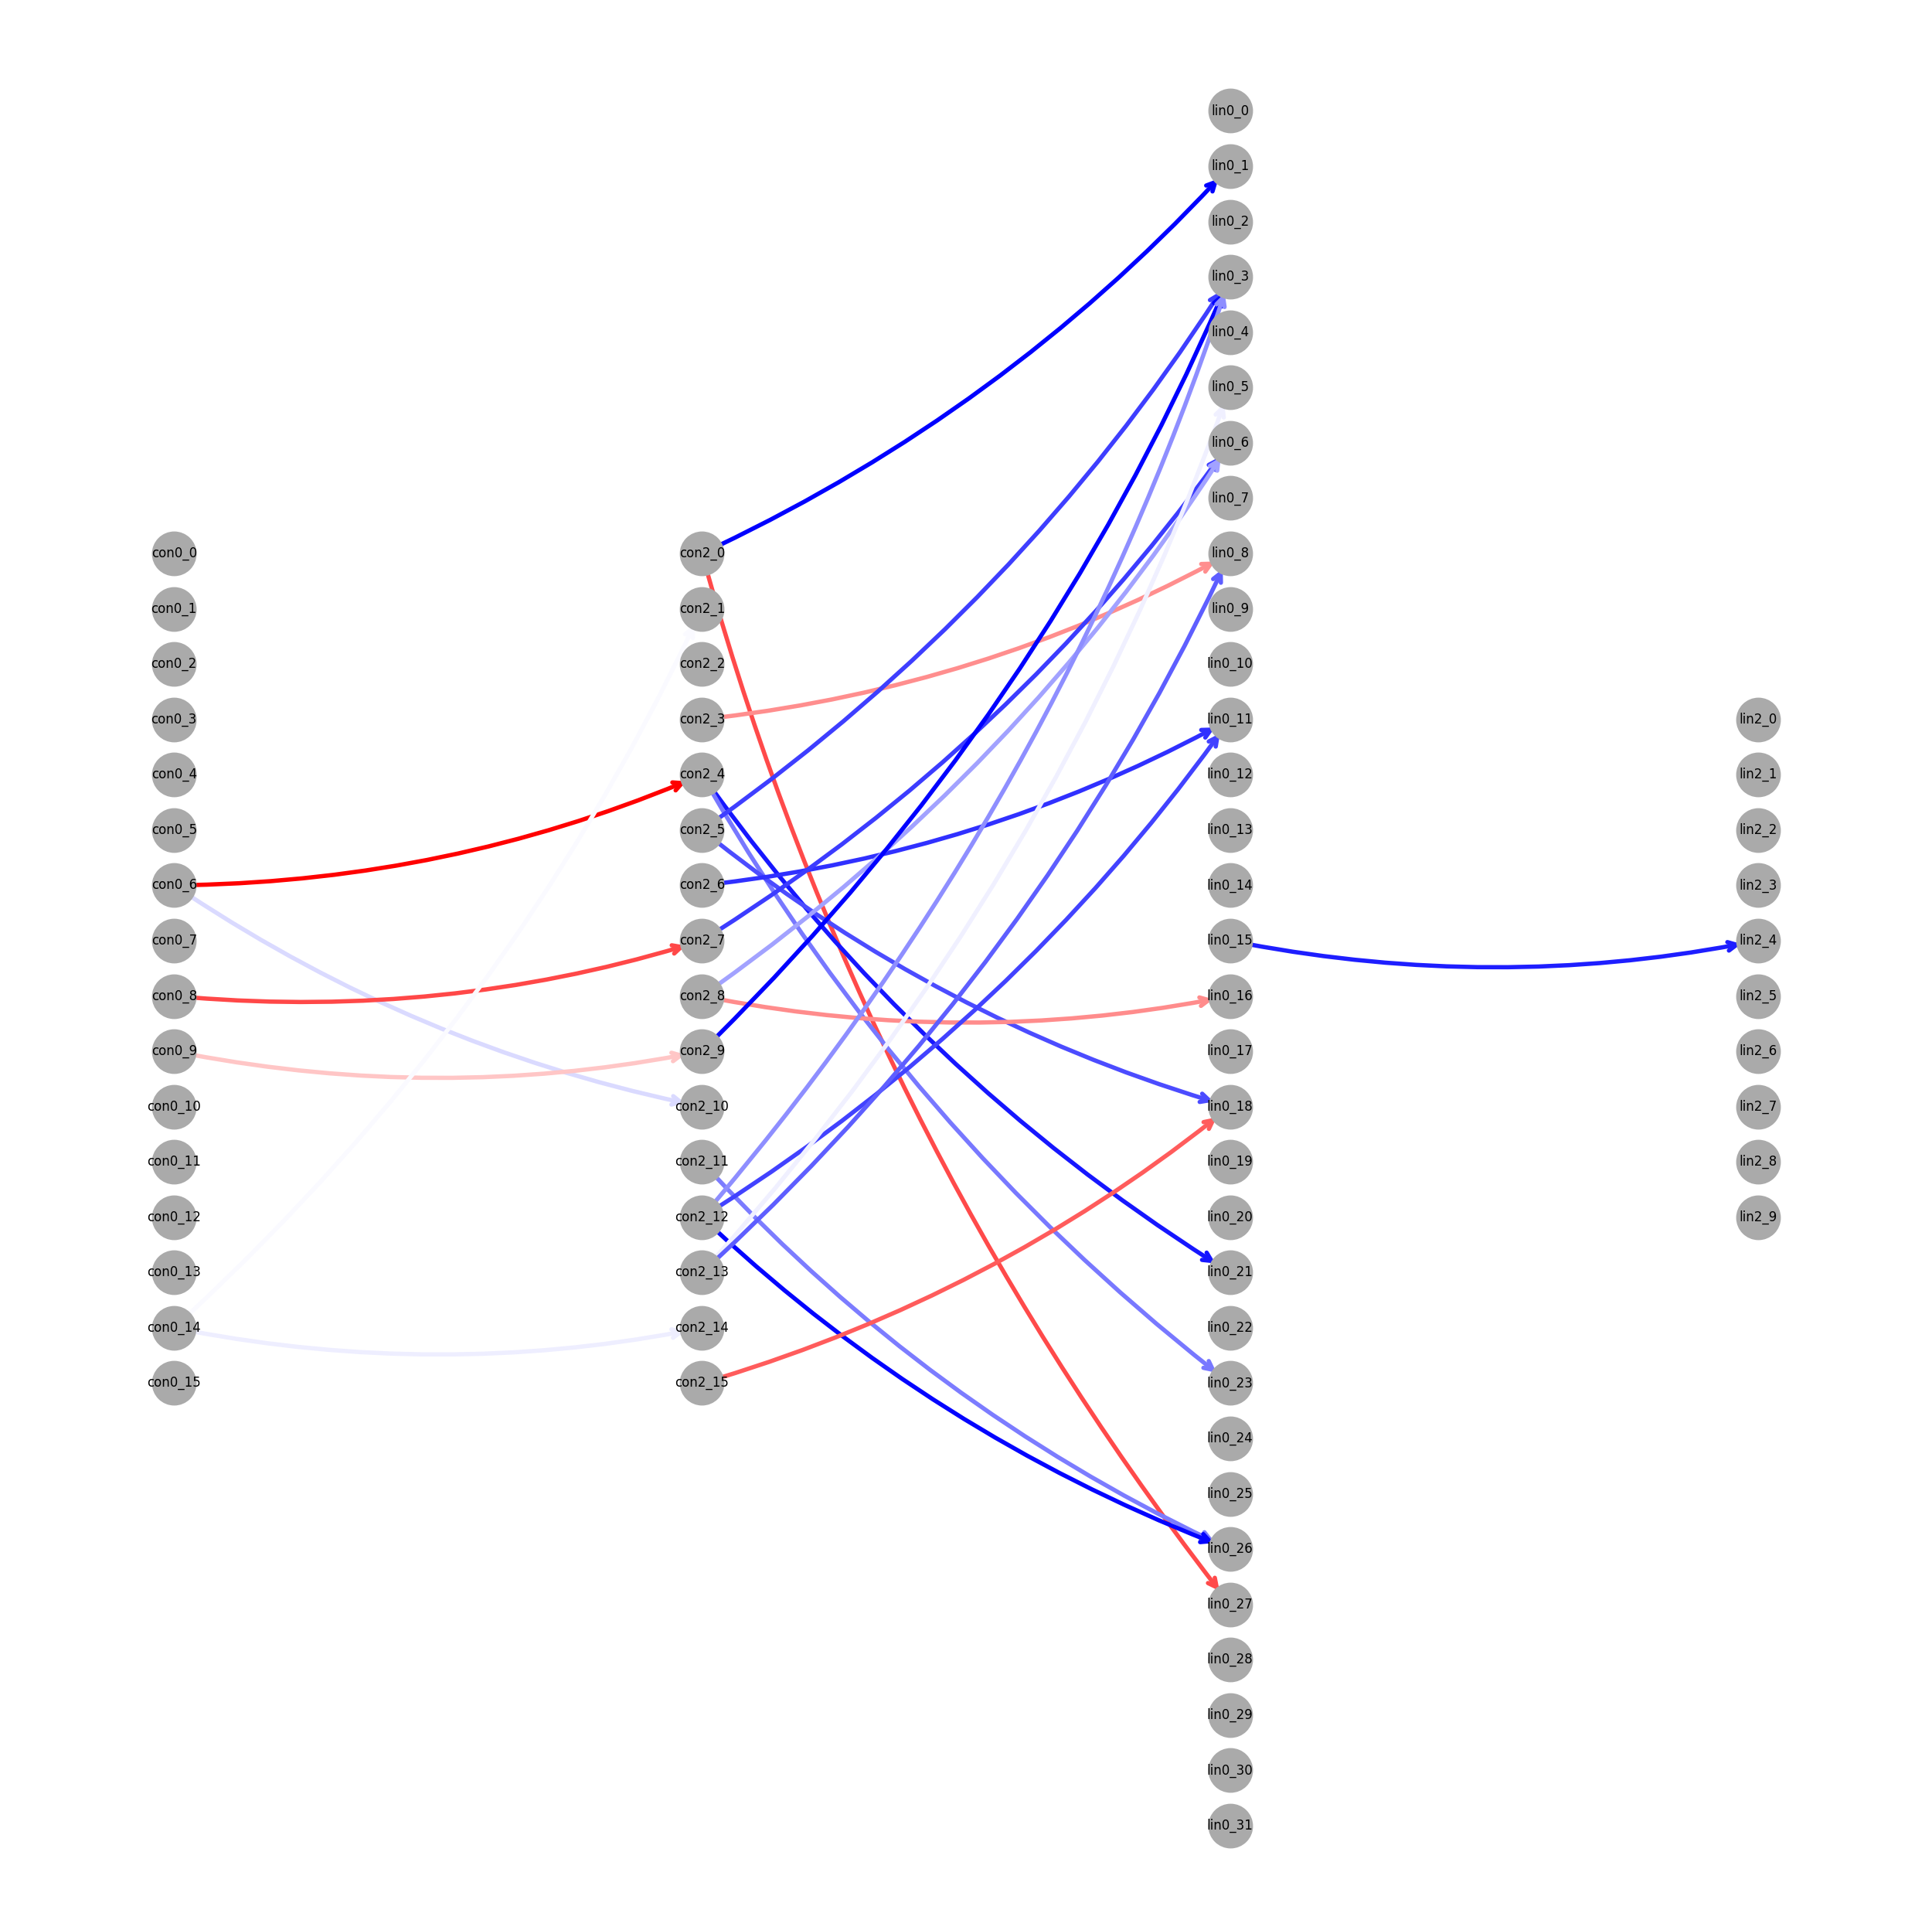

In [577]:

plot_multipartite(results, layers)


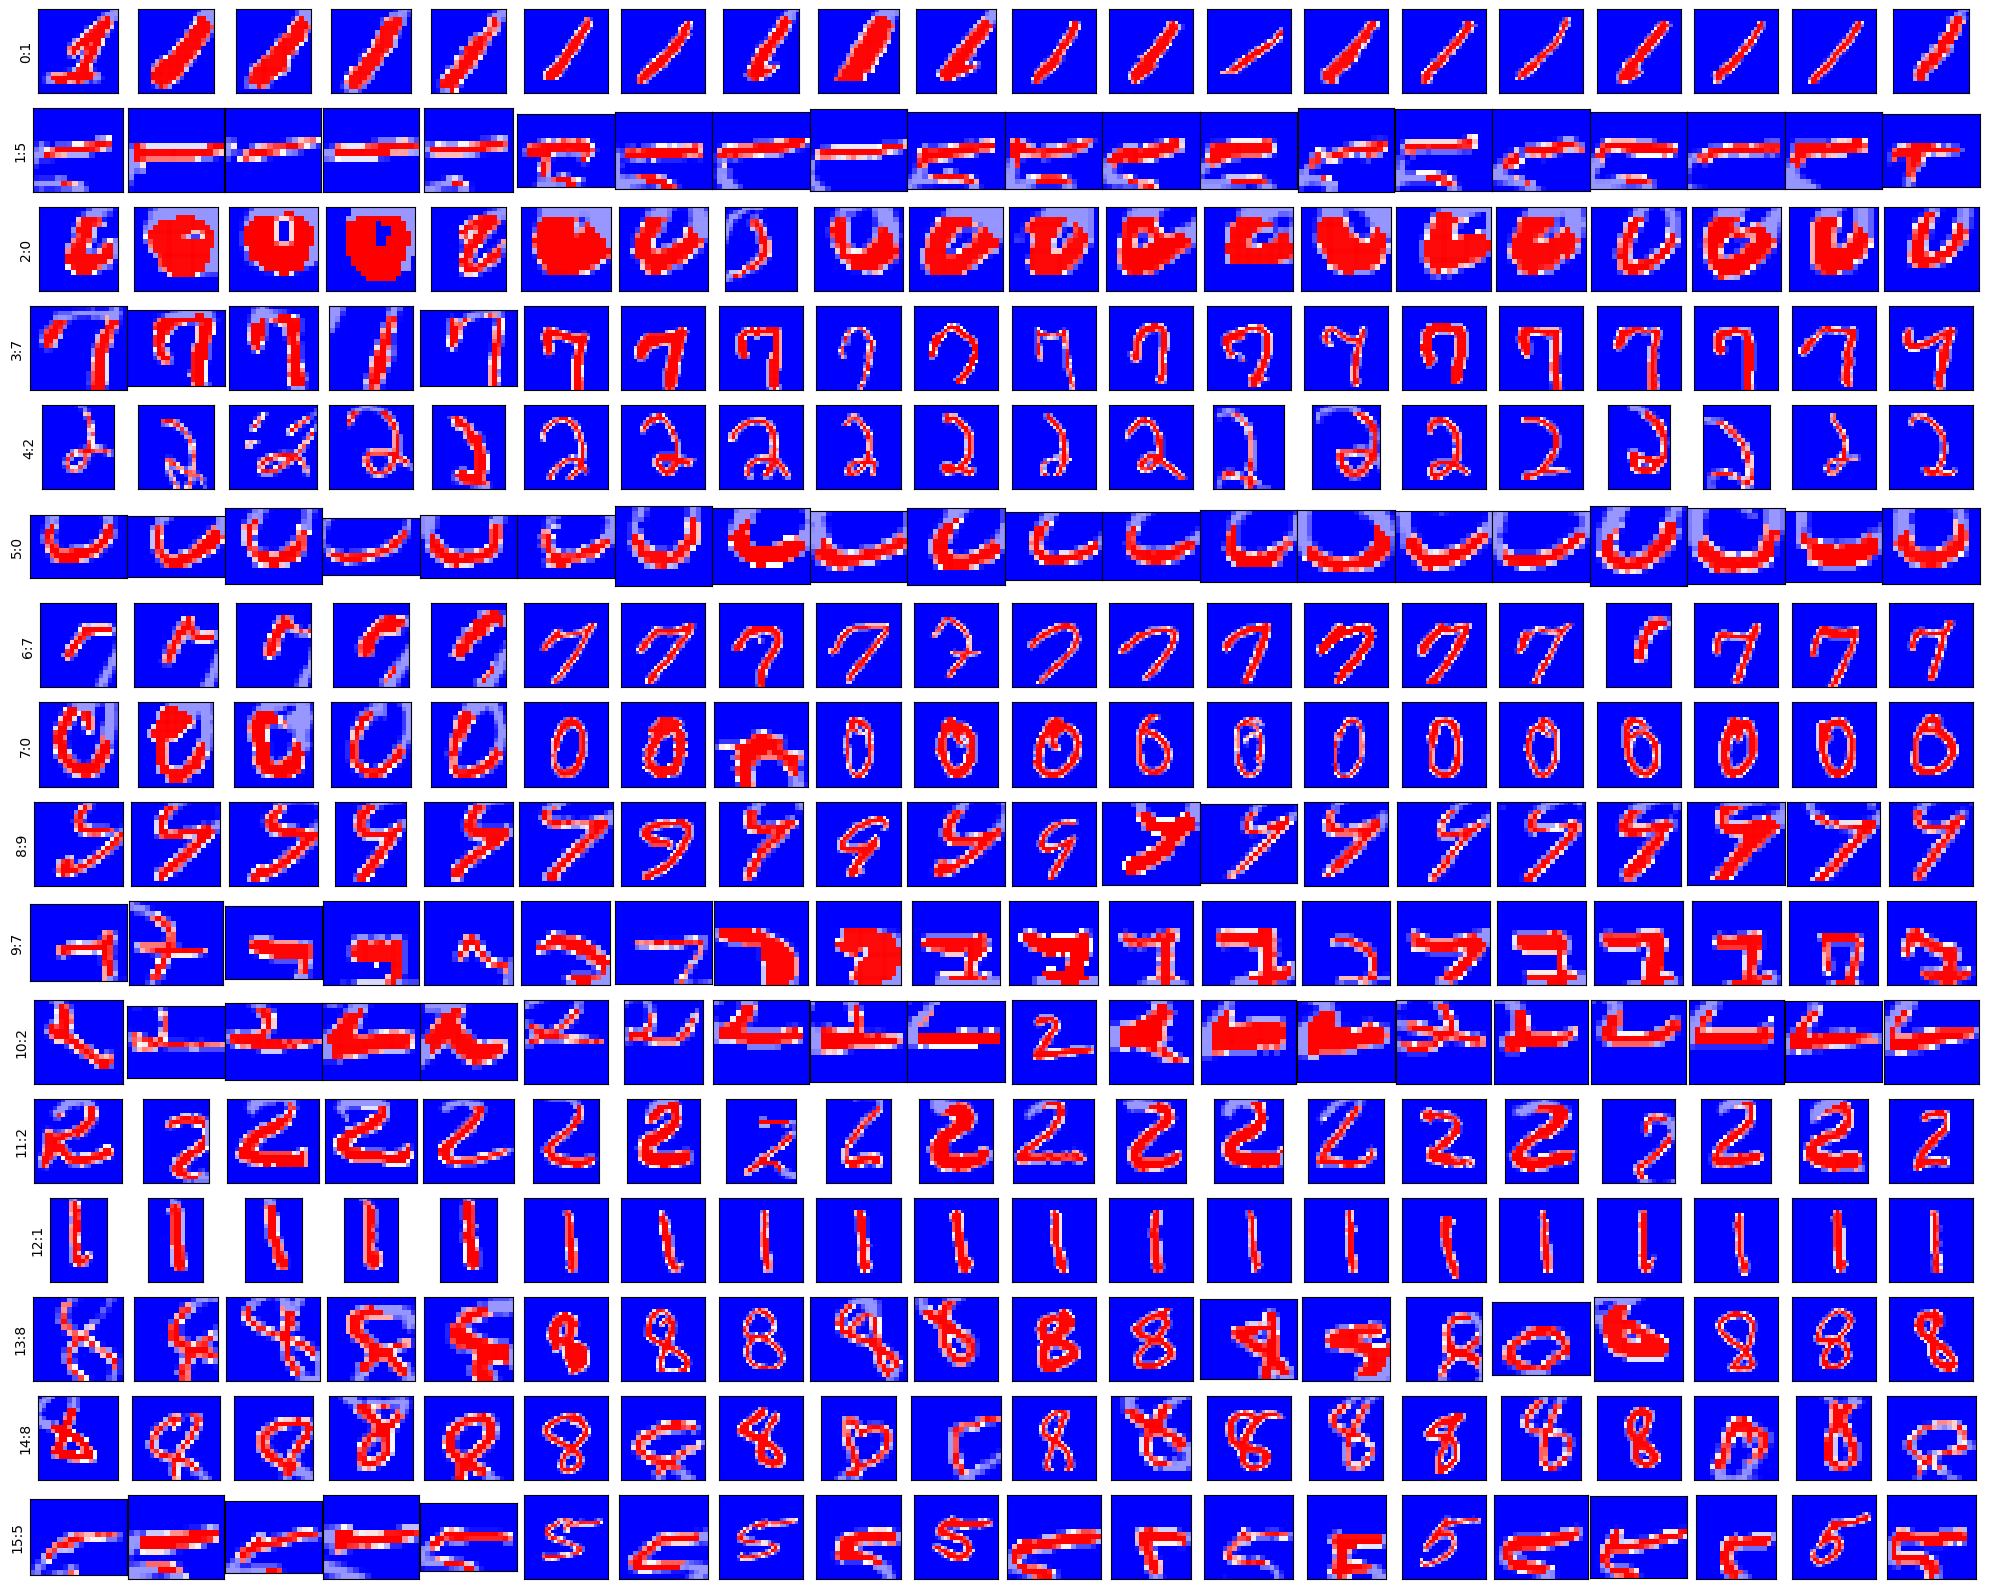

In [378]:
cond_layer, neurons = "convolutional_layers.2",range(16) 
#cond_layer, neurons = "linear_layers.0", range(32) 

all_refs = {}
for i in neurons:
    targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
    ref_c = fv.get_stats_reference(i, cond_layer,[targets], "relevance", (0, 20), composite=composite,rf=True, plot_fn=vis_opaque_img)
    all_refs[f'{i}:{targets}'] = ref_c[f'{i}:{targets}']
plot_grid(all_refs, figsize=(20, len(neurons)), padding=False, symmetric=True)

(768, 32)
number of intended variables: 32, actual number: 32, length of dataset: 768


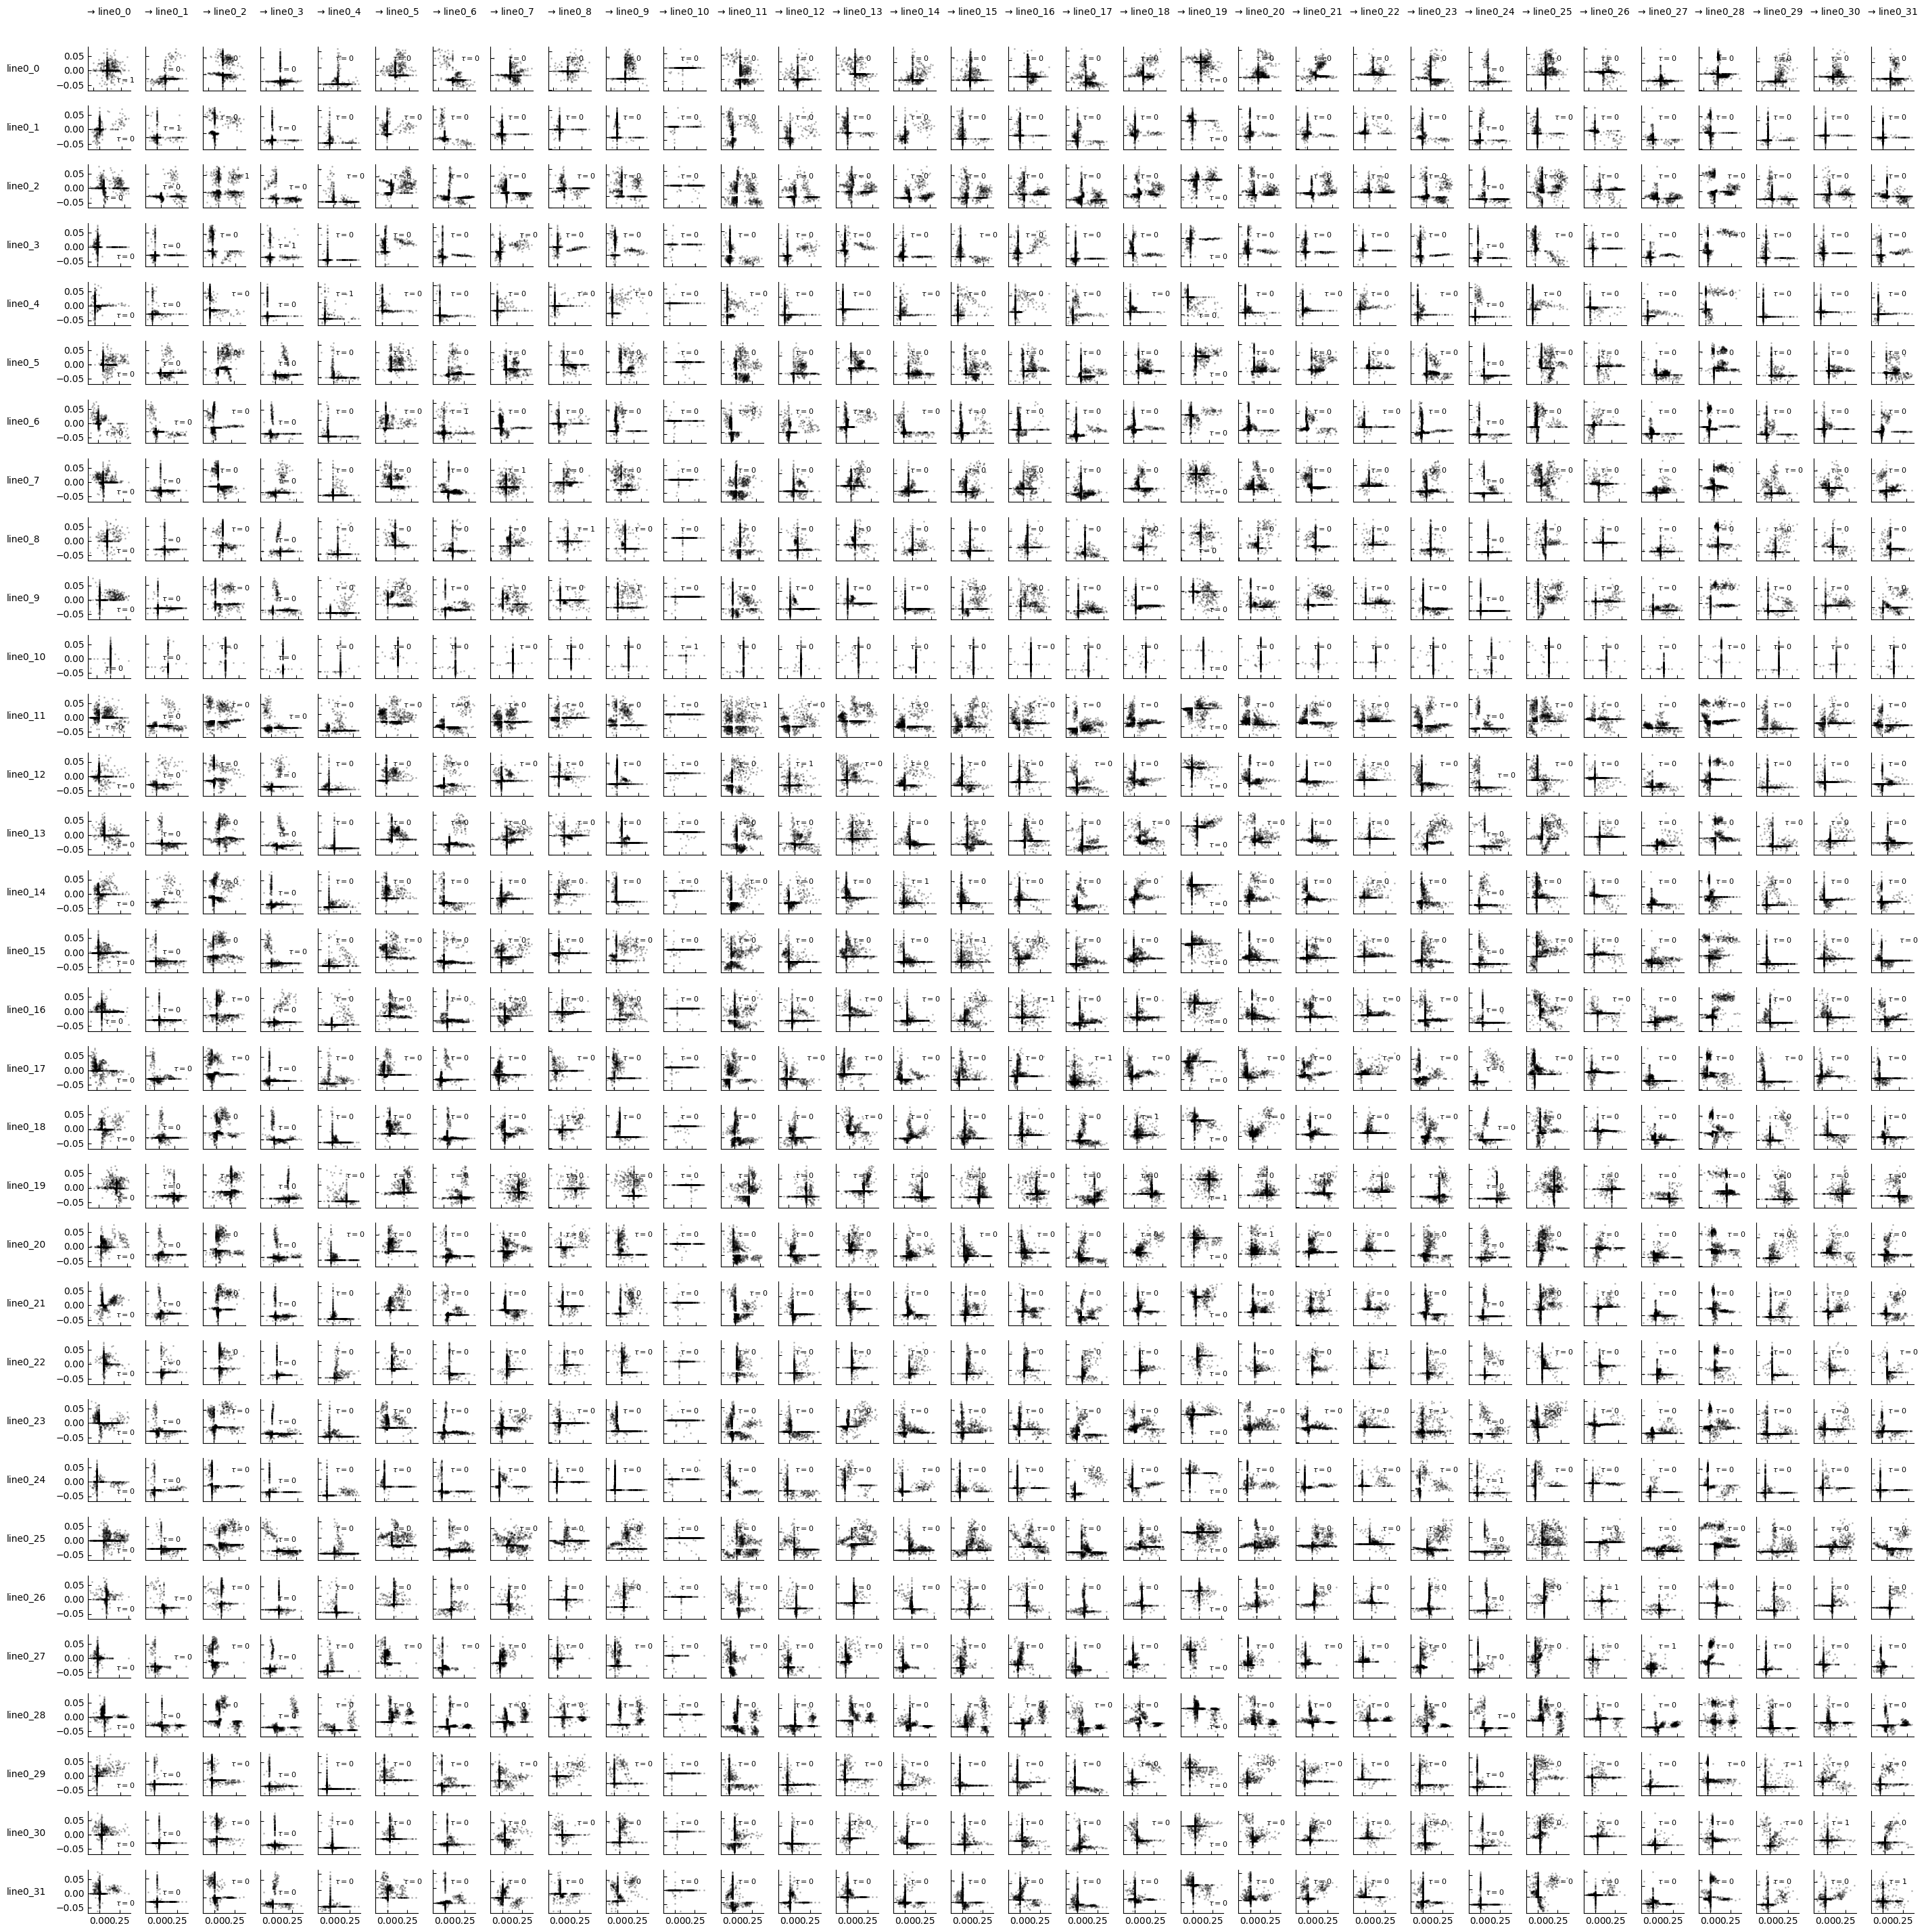

In [25]:

# create different datasets for each layer
#cond_layer = "convolutional_layers.0" #16 neurons
#cond_layer = "convolutional_layers.2" #16 neurons
cond_layer = "linear_layers.0" #32 neurons
#cond_layer = "linear_layers.2" #10 neurons (the output layer)
neurons = range(32)  # depending on how many neurons are in the layer
plot_dataframe,plot_var_names = create_dataframe(cond_layer, neurons, 6)

setup_args = {"figsize": (30,30),"label_space_left": 0.05,"label_space_top": 0.03}
tp.plot_scatterplots(dataframe=plot_dataframe, add_scatterplot_args={'matrix_lags':None}, 
                    setup_args=setup_args); plt.show()

In [ ]:
# it will take approximately 20 min on a Titan RTX
# run this only if you want to regenerate all the reference images visualizations
saved_files = fv.run(composite, 0, len(mnist_dataset), 20, 100)

Running Analysis...




  0%|                                                  | 0/3000 [00:00<?, ?it/s]

  0%|                                          | 7/3000 [00:00<00:49, 60.32it/s]

  0%|▏                                        | 14/3000 [00:00<00:58, 51.15it/s]

  1%|▎                                        | 20/3000 [00:00<00:59, 50.06it/s]

  1%|▎                                        | 26/3000 [00:00<01:01, 48.47it/s]

  1%|▍                                        | 31/3000 [00:00<01:02, 47.29it/s]

  1%|▍                                        | 36/3000 [00:00<01:03, 46.59it/s]

  1%|▌                                        | 41/3000 [00:00<01:03, 46.52it/s]

  2%|▋                                        | 46/3000 [00:00<01:04, 45.65it/s]

  2%|▋                                        | 51/3000 [00:01<01:05, 45.14it/s]

  2%|▊                                        | 56/3000 [00:01<01:06, 44.33it/s]

  2%|▊                                        | 61/3000 [00:01<01:05, 44.72it/s]

  2%|▉        

 33%|█████████████▎                          | 997/3000 [00:26<00:46, 43.52it/s]

 33%|█████████████                          | 1002/3000 [00:27<02:03, 16.23it/s]

 34%|█████████████                          | 1007/3000 [00:27<01:37, 20.34it/s]

 34%|█████████████▏                         | 1012/3000 [00:27<01:20, 24.60it/s]

 34%|█████████████▏                         | 1018/3000 [00:27<01:05, 30.24it/s]

 34%|█████████████▎                         | 1023/3000 [00:28<00:58, 33.56it/s]

 34%|█████████████▎                         | 1028/3000 [00:28<00:53, 36.81it/s]

 34%|█████████████▍                         | 1033/3000 [00:28<00:51, 38.11it/s]

 35%|█████████████▍                         | 1038/3000 [00:28<00:48, 40.14it/s]

 35%|█████████████▌                         | 1043/3000 [00:28<00:47, 41.29it/s]

 35%|█████████████▌                         | 1048/3000 [00:28<00:46, 41.63it/s]

 35%|█████████████▋                         | 1053/3000 [00:28<00:45, 42.89it/s]

 35%|███████████

 66%|█████████████████████████▌             | 1967/3000 [00:54<00:23, 44.56it/s]

 66%|█████████████████████████▋             | 1972/3000 [00:54<00:22, 45.31it/s]

 66%|█████████████████████████▋             | 1977/3000 [00:54<00:22, 45.71it/s]

 66%|█████████████████████████▊             | 1983/3000 [00:54<00:21, 48.04it/s]

 66%|█████████████████████████▊             | 1988/3000 [00:54<00:20, 48.34it/s]

 66%|█████████████████████████▉             | 1993/3000 [00:55<00:21, 46.98it/s]

 67%|█████████████████████████▉             | 1998/3000 [00:55<00:21, 47.24it/s]

 67%|██████████████████████████             | 2003/3000 [00:55<00:58, 16.98it/s]

 67%|██████████████████████████             | 2009/3000 [00:55<00:45, 21.96it/s]

 67%|██████████████████████████▏            | 2015/3000 [00:56<00:35, 27.45it/s]

 67%|██████████████████████████▎            | 2020/3000 [00:56<00:33, 29.57it/s]

 68%|██████████████████████████▎            | 2026/3000 [00:56<00:28, 34.38it/s]

 68%|███████████

100%|██████████████████████████████████████▉| 2993/3000 [01:22<00:00, 47.11it/s]

100%|███████████████████████████████████████| 3000/3000 [01:23<00:00, 35.85it/s]


100%|█████████████████████████████████████| 1200/1200 [00:00<00:00, 1932.50it/s]
